# Connect to GDrive and set working directory
## !! Skip if you run in local !!
1. Add a shortcut for working directory('IDPCode') to your drive as depicted below:
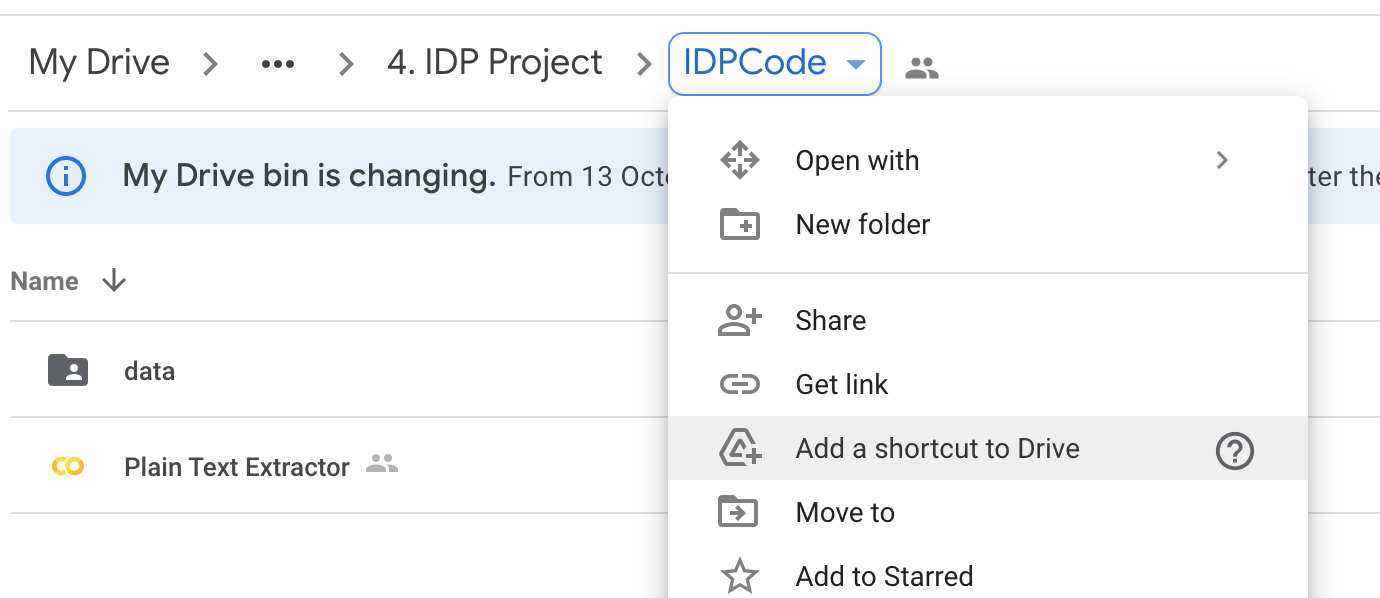
2. Run the command below to connect the GDrive:


In [ ]:
# https://github.com/njanakiev/folderstats
# https://janakiev.com/blog/python-filesystem-analysis/
# https://networkx.org/documentation/stable/
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/IDPCode/

In [64]:
!pip install xlrd
!pip install spacy
!pip install gensim
!pip install ipython-autotime
!pip install pickle5
!pip install textacy
!pip install spacy-langdetect
!pip install pandarallel

You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 81 kB 1.2 MB/s eta 0:00:01
  Created wheel for pandarallel: filename=pandarallel-1.5.1-py3-none-any.whl size=17126 sha256=9087c867f3b8c1e92b20b4d65c7d186812a92fa3bb99986f1c417233189e8624
  Stored in directory: /Users/farukcankaya/Library/Caches/pip/wheels/fb/b8/1f/0b548809b0ada9debfbd52f8dcbf8da60f7332a8f40bc63ece
Successfully built pandarallel
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
time: 15.5 s


# Start from here if you run in local !!

In [1]:
import pandas as pd
import numpy as np
import pickle5 as pickle
import gensim

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# show execution time of cells
%load_ext autotime

# CHANGE PATH FOR THE DATASET FOLDER
DATA_DIRECTORY='/Users/farukcankaya/FC/GoogleDrive/AllPapers'


time: 366 µs


In [2]:
# Utility functions
def remove_dollar_sign(text):
  '''
  While drawing title count distribution, mathplotlib throws an error.
  Because some titles have dollar sign('$'). This method is used to clear the sign.
  '''
  
  text = str(text).replace('$', '\$')
  return text

import re
import string
import textacy
from textacy import preprocessing
def clean_text(text):
  '''
  Eliminates links, non alphanumerics, and punctuation.
  Returns lower case text.
  '''  
  
  # Convert to string
  text = str(text)
  # Remove non-ascii
  text = text.encode('ascii', 'ignore').decode('ascii')
  # Remove links
  text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', '', text)
  # Remove E-Mail addresses
  text = re.sub(r'\b[a-z]+@[a-z]+\b', r'', str(text))
  # Remove non-alphanumerics
  text = re.sub('\w*\d\w*', ' ', text)
  # Remove punctuation and lowercase
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text.lower())
  # Remove newline characters
  text = re.sub("\n", r' ', text)
  # Remove text in square brackets
  text = re.sub(r'\[.*?\]', '', text)
  # Remove words containing numbers
  text = re.sub(r'\w*\d\w*', '', text)
  # https://textacy.readthedocs.io/en/0.10.1/_modules/textacy/preprocessing/normalize.html
  text = textacy.preprocessing.normalize.normalize_whitespace(str(text))
  # replace words with less than 2 characters
  text = re.sub(r'\b[a-z]{1,2}\b', r'', str(text))
    
  return text

import spacy
nlp = spacy.load('en')
def lemmatizer(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):        
  sent = []
  doc = nlp(text)
#  for word in doc:
#    sent.append(word.lemma_)
  sent =  [token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]
    
  return " ".join(sent)

# Lemmatization, remove pronouns.
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        texts_out.append(lemmatizer(" ".join(sent), allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']))
    return texts_out

def remove_stopwords(text):
  clean_text = []
  for word in text.split(' '):
    if word not in stop_list and (len(word) > 2):
      clean_text.append(word)
  
  return ' '.join(clean_text)

def display_topics(model, feature_names, no_top_words, no_top_topics, topic_names=None):
  count = 0
  for ix, topic in enumerate(model.components_):
    if count == no_top_topics:
      break
    if not topic_names or not topic_names[ix]:
      print("\nTopic ", (ix + 1))
    else:
      print("\nTopic: '",topic_names[ix],"'")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))
    count += 1
    
def word_count(text):
    return sum([i.strip(string.punctuation).isalpha() for i in text.split()])
  
from IPython.core.display import display, HTML
def print_html(data):
  display(HTML('<div style="width: 90%">'+data+'</div>'))
  
  
def print_lemmatized(text, colorized_ignored=False, ignore_type='allowed'):
  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
  doc_lemma = nlp(text)
  lemms = []
  poses = []
  #colors = ['#f88f88','#DA553F','#045E5B','#731425','#F61E9E','#f44f44','#ff0','#0ff','#f0f']  
  import random
  r = lambda: random.randint(0,255)
  colors = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(30)]

  for token in doc_lemma:
    if token.pos_ not in poses:
      poses.append(token.pos_)

  print(poses)
  for token in doc_lemma:
    if (ignore_type=='allowed' and token.pos_ not in allowed_postags) or (ignore_type=='stop_word' and token.is_stop):
      ignored_color = '#FF8983' if colorized_ignored else colors[poses.index(token.pos_)]
      
      lemms.append('<span style="color: #fff; padding: 0 10px; background-color: '+ignored_color+'"> '+token.lemma_+' </span>')
    else:
      lemms.append(token.lemma_)
      
  print_html('allowed_postags: '+' '.join(['<span style="color: #fff; padding: 0 10px; background-color: '+colors[allowed_postags.index(i)]+'"> '+i+' </span>' for i in allowed_postags]))
  print_html('available: '+' '.join(['<span style="color: #fff; padding: 0 10px; background-color: '+colors[poses.index(i)]+'"> '+i+' </span>' for i in poses]))
  print_html(' '.join(lemms))
  
import os
def get_file_name(file_path):
  f = os.path.basename(file_path)
  return f.replace('.pdf', '')

def run_in_parallel(dt, function, n_cores=8):
    df_n = np.array_split(df, n_cores)

    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_n))
    pool.close()
    pool.join()
    return df

time: 2.02 s


# Initial Info about the dataset
The dataset in 'All_Papers_In_Plain_Text_TIKA.pkl' contains extracted text page by page per document. Each document has one row and has columns as much as they need in the dataset. Any datapreprocessing step is not applied to data in 'All_Papers_In_Plain_Text_TIKA.pkl'. It is not even normalized. It has many documents that have just one page. Our purpose here was to test the accuracy value against different datapreprocessing steps as simple as we can. Afterwards, we will do further tests by normalizing the data. So to summerize:
- We use all 15750 document that we have as it is
- We used Tika to extract the texts from PDF documents
- We didn't exclude any documents based on their relavences
- We didn't normalized the data, it may contain wrong extracted text

## You can skip '1. Data pre-processing' section and use  the pre-processed data by the code below:

In [ ]:
dt = pd.read_pickle('cleaned_stop_words_lemmatized_stemmed_all_pages_separetely.pkl') # https://drive.google.com/file/d/1UIqL13xHHGDlBomMsfin8g6inhuvOGuc/view?usp=sharing

# 1. Data pre-processing

In [3]:
# dt = Dataset Tika
dt = pd.read_pickle('All_Papers_In_Plain_Text_TIKA.pkl') # https://drive.google.com/file/d/1mF88eFEKtni3Sr8jYo2Yo6-rqIunbMgi/view?usp=sharing

time: 1min 5s


In [27]:
## TEST
print(dt[['cp:subject', 'dc:description', 'description', 'pdf:docinfo:subject', 'subject']].isna().sum())
#print(dt['subject'].isna())
#cp:subject, dc:description, description, pdf:docinfo:subject, subject
for i in dt[dt['subject'].isna() == False]['subject'].unique():
  print(i)
  
# Accounting Horizons 2016.30:427-447 => Remove last part  ' ([0-9]+)\.([0-9]+):([a-z]+|[0-9]+)\-([a-z]+|[0-9]+)'
# Remove doi =>' , doi:(.*)'
# The British Accounting Review, =>'([a-zA-z ]+),(.*)'
# remove ' \(([0-9]+)\)(.*)'
# 'Vol\. (.*)\n'
# 'http(.*)\n'
# '\.\.\.'
# 

cp:subject             10114
dc:description         11971
description            11971
pdf:docinfo:subject    10114
subject                 9369
dtype: int64
Accounting Horizons 2009.23:365-389
Accounting Horizons 2014.28:193-203
Accounting Horizons 2013.27:909-918
Accounting Horizons 2015.29:363-375
Accounting Horizons 2012.26:219-237
Accounting Horizons 2008.22:315-338
Accounting Horizons 2018.32:81-102
Accounting Horizons 2018.32:163-182
Accounting Horizons 2015.29:439-449
Accounting Horizons 2011.25:487-510
Accounting Horizons 2009.23:201-220
Accounting Horizons 2016.30:173-174
Accounting Horizons 2018.32:65-85
Accounting Horizons 2013.27:799-813
Accounting Horizons 2015.29:245-264
Accounting Horizons 2011.25:71-86
Accounting Horizons 2014.28:957-960
Accounting Horizons 2012.26:353-355
Accounting Horizons 2007.21:447-450
Accounting Horizons 2013.27:i-vii
Accounting Horizons 2010.24:671-688
Accounting Horizons 2001.15:193-207
Accounting Horizons 2011.25:685-702
Accounting Horizons 2

Accounting Horizons 2000.14:211-233
Accounting Horizons 2015.29:529-549
Accounting Horizons 2009.23:85-100
Accounting Horizons 2014.28:627-671
Accounting Horizons 2002.16:137-151
Accounting Horizons 2017.31:57-81
Accounting Horizons 2018.32:123-143
Accounting Horizons 2014.28:17-37
Accounting Horizons 2004.18:157-172
Accounting Horizons 2016.30:225-238
Accounting Horizons 2000.14:441-454
Accounting Horizons 2012.26:193-217
Accounting Horizons 2014.28:313-330
Accounting Horizons 2002.16:277-289
Accounting Horizons 2017.31:129-139
Accounting Horizons 1999.13:113-128
Accounting Horizons 2000.14:501-508
Accounting Horizons 2016.30:325-339
Accounting Horizons 2004.18:185-196
Accounting Horizons 2014.28:93-123
Accounting Horizons 2018.32:163-183
Accounting Horizons 2016.30:393-408
Accounting Horizons 2002.16:219-232
Accounting Horizons 2014.28:125-142
Accounting Horizons 2012.26:493-511
Accounting Horizons 2001.15:105-118
Accounting Horizons 2016.30:79-91
Accounting Horizons 2013.27:619-646


The Accounting Review 2003.78:397-428
The Accounting Review 2008.83:1101-1124
The Accounting Review 2014.89:79-112
The Accounting Review 2008.83:1251-1272
The Accounting Review 2014.89:209-242
The Accounting Review 2012.87:761-796
The Accounting Review 2009.84:811-837
The Accounting Review 2009.84:623-658
The Accounting Review 2011.86:1415-1444
The Accounting Review 2012.87:807-837
The Accounting Review 2015.90:2515-2536
The Accounting Review 2016.91:99-117
The Accounting Review 2011.86:259-286
The Accounting Review 2016.91:1751-1780
The Accounting Review 2019.94:153-181
The Accounting Review 2017.92:123-149
The Accounting Review 1999.74:347-369
The Accounting Review 1999.74:87-104
The Accounting Review 2013.88:1683-1714
The Accounting Review 2013.88:1179-1210
The Accounting Review 2002.77:127-160
The Accounting Review 2001.76:515-536
The Accounting Review 2018.93:299-325
The Accounting Review 2018.93:133-161
The Accounting Review 2016.91:69-98
The Accounting Review 2016.91:489-511
The

Management Accounting Research, 26 (2015) IFC. doi:10.1016/S1044-5005(15)00003-7
Management Accounting Research, 35 (2017) 1-4. doi:10.1016/j.mar.2016.05.001
Management Accounting Research, 24 (2013) 23-40. 10.1016/j.mar.2012.11.001
Management Accounting Research, 24 (2013) 64-79. 10.1016/j.mar.2012.12.002
Management Accounting Research, 38 (2018) 22-38. doi:10.1016/j.mar.2017.03.003
Management Accounting Research, 21 (2010) 238-250. 10.1016/j.mar.2010.07.001
Management Accounting Research, 41 (2018) 11-19. doi:10.1016/j.mar.2018.02.003
Management Accounting Research, 24 (2013) 261-275. doi:10.1016/j.mar.2013.01.001
Management Accounting Research, 36 (2017) 51-66. doi:10.1016/j.mar.2016.10.001
Management Accounting Research, 24 (2013) III. 10.1016/S1044-5005(13)00020-6
Management Accounting Research, 32 (2016) 1-15. doi:10.1016/j.mar.2015.10.002
Management Accounting Research, 22 (2011) 142. 10.1016/j.mar.2011.06.005
Management Accounting Research, 22 (2011) 143-159. 10.1016/j.mar.2011

In [33]:
t = ["Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","Accounting Horizons","","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review ","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","YBARE","The British Accounting Review","British Accounting Review","British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","The British Accounting Review","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","IFRS; Earnings management; Thresholds","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Journal of Accounting and Public Policy","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Review of Accounting Studies","Review of Accounting Studies","Review of Accounting Studies","Review of Accounting Studies","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Review of Accounting Studies","Rev Account Stud","Review of Accounting Studies","Review of Accounting Studies","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Review of Accounting Studies","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Review of Accounting Studies","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Review of Accounting Studies","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Review of Accounting Studies","Review of Accounting Studies","Review of Accounting Studies","Review of Accounting Studies","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Review of Accounting Studies","Review of Accounting Studies","Review of Accounting Studies","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Review of Accounting Studies","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Review of Accounting Studies","Review of Accounting Studies","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Rev Account Stud","Review of Accounting Studies","Review of Accounting Studies","Rev Account Stud","Rev Account Stud","Review of Accounting Studies","Review of Accounting Studies","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","European Accounting Review","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Accounting and Business Research","Earnings; Firm size; Market efficiency; Momentum","SFAS No","Outsourcing; Agency theory; Internal audit; Audit risk","Audit quality; Earnings forecast","Audit committees; Corporate governancemittee knowledge and experience;","Cost of capital; Disclosure; Information asymmetry; Stock offering","Methodological biasesax; Book income adjustment; Earnings management;","Competition; Cost accounting; Decision making; Learning","auditing market; Modified audit opinions; Market reaction; Independent","Financial information; Residual income model; Terminal values; Valuation","disclosuresnge; Earnings quality; Earnings response coefficients; Form 8-K","Accounting recognition; Moral hazard; Communication; Agency theory","Agency model; CEO compensation; Shielding; Strategic expenditures","Delegation; Incentive contracts; Performance measurement; Private information","Stock options; Taxation; Financial reporting; Hypothesis testing","Cash bonuses; Economic conditions; Financial targets; Management compensation","Double entry; Aggregation; Subspaces; Estimation","testingic auditing; Internal control assessment; Audits for fraud; Substantive","Communication; Corporate annual reports; Financial graphs; Manipulation","Cooperation; Experimental economics; Reputation; Verification","Contemporary Accounting Research","managementothing; R&D expenditures; Japanese managers; Earnings","Accountability; Analytical procedures; Auditor-testing strategies; Time budgets","Auditors’ risk assessments; Confidence; Industry specialization","Audit workpapers; Memo structure; Preparer’s conclusion; Review process","Transfer prices; Taxes; Competition; Organizational structure","Earnings dilutionr share; Diluted earnings per share; Treasury stock method;","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","International Tax and Public Finance","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","The Accounting Review","An Evaluation of the Effect","Improving Analytical Procedures: A Case","Auditor's Evaluation of Evidence Obtained","A Comparative Evaluation of belief","The Role of Big 6","Chen et al","The Effects of Fee Pressure","An Analysis of the Relative","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Acconting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accointing","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","","","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives of Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical  Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical  Perspectives on  Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspective on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives  on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspecives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Prespectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting ","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectivres on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Critical Perspectives on Accounting","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Accounting Forum","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Materiality; Voluntary disclosures; Legal liability","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Analysts; Conservatism; Earnings forecasts; Market reaction","Endogeneity; Instrumental variables; Disclosure; Cost of capital","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Analysts recommendations; Brokerage research; Capital markets; Investment banking; Market efficiency; Security analysts","Securitizations; Fair value; Earnings management; Compensation; Governance","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Financial reporting quality; Capital investment","Journal of Accounting and Economics","JEL classification:; G20; G30; M41; Asset securitizations; Securitization income; Earnings management; Fair value","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Insider trading; Stock market; Earnings announcements; Behavioral finance","Management forecasts; Conservatism; Credibility","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Disclosure; Voluntary disclosure; Materiality; Advertising; Partial observability model","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Analyst research; Information content; Earnings announcements; Information discovery","Book-tax differences; IFRS; Informativeness of book-tax differences; Tax-based accounting system; Tax noncompliance","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Auditor choice; Privatization; Disclosure; Corporate governance","Information risk; PIN; Risk","CEO compensation; Relative performance evaluation; Peer group","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Loss/profit mispricing; Loss/profit predictability; Accounting losses/profits; Post-earnings-announcement drift; Earnings-based anomalies","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Seasoned equity offerings; Earnings management; Accounting choices; Accounting Accruals; Real activities","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Depreciation method choice; Capital investments; Straight-line depreciation; Accelerated depreciation","Information asymmetry; Earnings surprises; Investor recognition hypothesis","Journal of Accounting and Economics","Conservatism; Asymmetric timeliness; Firm-year measure; Information asymmetry; Litigation","Sarbanes-Oxley; Legislative policy; Corporate risk-taking; Investment policy","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Accruals; Persistence; Management forecasts; Forecast errors","Employee stock options; Firm performance; Option repricing","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Conservatism; Impairment; Debt contracting; Asset measurement","Auditors; PCAOB; Peer Reviews; Regulation; Sarbanes-Oxley","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Audit fees; CEO compensation; Complexity; Entrenchment; Risk","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Audit committees; Board of director compensation; Audit fees","Journal of Accounting and Economics","Executive compensation; Compensation consultants; Corporate advisors","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","CFO Turnover; Professional qualifications; Internal control; SOX 404","Journal of Accounting and Economics","Executive compensation; Disclosure; Corporate governance; Board of directors; Compensation consultants","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Voluntary disclosure; Managerial perceptions; Product market competition; Industry concentration","Regulation; Sarbanes–Oxley act; PCAOB","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Book-tax conformity; Book-tax differences; Usefulness of earnings; Earnings persistence; Future cash flows","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Timely loss recognition; Agency costs; Accounting conservatism; Corporate governance; Acquisitions; Divestitures","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Auditor tenure; Auditor industry specialization; Low balling; Earnings quality","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Internal controls; Financial reporting quality; FDICIA; Loan-loss provision; Reporting discretion","Performance measurement; Corporate governance; Corporate democracy; Director elections","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Management guidance; Management forecast accuracy; Internal control over financial reporting","FDI; Financial reporting quality; FDICIA; SOX","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","SFAS 133; Derivative financial instruments; Risk-management behavior","Implied volatility; Earnings guidance; Management forecasts; Uncertainty","Journal of Accounting and Economics","Journal of Accounting and Economics","Journal of Accounting and Economics","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","ACCOUNTING","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","AOS","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","AOS","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","AOS","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","AOS","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","AOS","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","AOS","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","AOS","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","AOS","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","AOS","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","AOS","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","AOS","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","AOS","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","Accounting","AOS","Accounting","Accounting","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","International Journal of Accounting Information Systems","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management  Accounting  Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Management Accounting Research","Accounting research and policy making.","Research in managerial accounting: Learning","The structure of profit sharing","Implicit deposit insurance and deposit ","In defence of the survey","Experimental research method in a","The information environment and the","Capital markets research and accounting","A framework for the analysis","Vale to Louis Goldberg."]

time: 31.4 ms


In [34]:
uniq_t = list(set(t))

time: 889 µs


In [43]:
clean_uniq_t = []
to_parse = []
for i in uniq_t:
  if not ";" in i and not i == '':
    clean_uniq_t.append(i)
  else:
    to_parse.append(i)



time: 575 µs


In [44]:
clean_uniq_t

['The Effects of Fee Pressure',
 'Accounting Forum',
 'Capital markets research and accounting',
 'International Journal of Accounting Information Systems',
 'Management  Accounting  Research',
 'A Comparative Evaluation of belief',
 'Experimental research method in a',
 "Auditor's Evaluation of Evidence Obtained",
 'An Analysis of the Relative',
 'A framework for the analysis',
 'The British Accounting Review',
 'An Evaluation of the Effect',
 'Accounting',
 'ACCOUNTING',
 'Journal of Accounting and Economics',
 'Review of Accounting Studies',
 'Accounting Horizons',
 'Critical Perspective on Accounting',
 'Accounting research and policy making.',
 'British Accounting Review ',
 'European Accounting Review',
 'Critical Prespectives on Accounting',
 'AOS',
 'Contemporary Accounting Research',
 'Vale to Louis Goldberg.',
 'Rev Account Stud',
 'The Role of Big 6',
 'Critical  Perspectives on Accounting',
 'Critical Perspectives on Accounting',
 'Critical Perspectives on Accointing',
 'Th

time: 4.05 ms


In [49]:
to_parse

['',
 'Financial reporting quality; Capital investment',
 'disclosuresnge; Earnings quality; Earnings response coefficients; Form 8-K',
 'Securitizations; Fair value; Earnings management; Compensation; Governance',
 'Information risk; PIN; Risk',
 'Earnings; Firm size; Market efficiency; Momentum',
 'Regulation; Sarbanes–Oxley act; PCAOB',
 'Executive compensation; Disclosure; Corporate governance; Board of directors; Compensation consultants',
 'Analysts recommendations; Brokerage research; Capital markets; Investment banking; Market efficiency; Security analysts',
 'Accounting recognition; Moral hazard; Communication; Agency theory',
 'Book-tax differences; IFRS; Informativeness of book-tax differences; Tax-based accounting system; Tax noncompliance',
 'Depreciation method choice; Capital investments; Straight-line depreciation; Accelerated depreciation',
 'Audit committees; Board of director compensation; Audit fees',
 'Conservatism; Impairment; Debt contracting; Asset measurement',

time: 3.06 ms


In [50]:
parsed = []
for x in to_parse:
  l = x.split('; ')
  for i in l:
    if not ";" in i and not i == '':
      parsed.append(i)

time: 877 µs


In [51]:
parsed

['Financial reporting quality',
 'Capital investment',
 'disclosuresnge',
 'Earnings quality',
 'Earnings response coefficients',
 'Form 8-K',
 'Securitizations',
 'Fair value',
 'Earnings management',
 'Compensation',
 'Governance',
 'Information risk',
 'PIN',
 'Risk',
 'Earnings',
 'Firm size',
 'Market efficiency',
 'Momentum',
 'Regulation',
 'Sarbanes–Oxley act',
 'PCAOB',
 'Executive compensation',
 'Disclosure',
 'Corporate governance',
 'Board of directors',
 'Compensation consultants',
 'Analysts recommendations',
 'Brokerage research',
 'Capital markets',
 'Investment banking',
 'Market efficiency',
 'Security analysts',
 'Accounting recognition',
 'Moral hazard',
 'Communication',
 'Agency theory',
 'Book-tax differences',
 'IFRS',
 'Informativeness of book-tax differences',
 'Tax-based accounting system',
 'Tax noncompliance',
 'Depreciation method choice',
 'Capital investments',
 'Straight-line depreciation',
 'Accelerated depreciation',
 'Audit committees',
 'Board of d

time: 5.73 ms


In [54]:
combined = list(set(parsed + clean_uniq_t))
print(len(combined))
combined

270


['Outsourcing',
 'managementothing',
 'The Effects of Fee Pressure',
 'Relative performance evaluation',
 'Impairment',
 'Agency theory',
 'Acquisitions',
 'FDICIA',
 'Accounting Forum',
 'Tax noncompliance',
 'Litigation',
 'Performance measurement',
 'Agency costs',
 'Securitization income',
 'Management guidance',
 'Thresholds',
 'Corporate risk-taking',
 'Subspaces',
 'SOX',
 'Legislative policy',
 'Financial graphs',
 'Accelerated depreciation',
 'Market efficiency',
 'Internal control',
 'Capital markets research and accounting',
 'Corporate advisors',
 'Loss/profit mispricing',
 'International Journal of Accounting Information Systems',
 'Agency model',
 'Compensation',
 'Audits for fraud',
 'Management  Accounting  Research',
 'Investment banking',
 'Internal audit',
 'A Comparative Evaluation of belief',
 'Book-tax conformity',
 'Experimental research method in a',
 'Double entry',
 "Auditor's Evaluation of Evidence Obtained",
 'Straight-line depreciation',
 'An Analysis of th

time: 6.65 ms


In [60]:
clean_combined = []
for i in combined:
  c = clean_text(i)
  if not c in clean_combined and c != '':
    clean_combined.append(c) 

time: 10.9 ms


In [61]:
clean_combined

['outsourcing',
 'managementothing',
 'the effects  fee pressure',
 'relative performance evaluation',
 'impairment',
 'agency theory',
 'acquisitions',
 'fdicia',
 'accounting forum',
 'tax noncompliance',
 'litigation',
 'performance measurement',
 'agency costs',
 'securitization income',
 'management guidance',
 'thresholds',
 'corporate risk taking',
 'subspaces',
 'sox',
 'legislative policy',
 'financial graphs',
 'accelerated depreciation',
 'market efficiency',
 'internal control',
 'capital markets research and accounting',
 'corporate advisors',
 'loss profit mispricing',
 'international journal  accounting information systems',
 'agency model',
 'compensation',
 'audits for fraud',
 'management accounting research',
 'investment banking',
 'internal audit',
 ' comparative evaluation  belief',
 'book tax conformity',
 'experimental research method  ',
 'double entry',
 'auditor  evaluation  evidence obtained',
 'straight line depreciation',
 ' analysis  the relative',
 'earn

time: 5.73 ms


In [67]:
bad_word_list = ['accounting']
good_word_list = ["doi",
                  "vol",
                  "managerial auditing journal",
                  "mcb university press",
                  "issn"
                  "management accounting research",
                  "springer science business",
                  "new york",
                  "american accounting association",
                  "international tax and public finance",
                  "copyright",
                  "account public policy",
                  "accounting auditing accountability journal",
                  "aaaj",
                  "accounting forum",
                  "accounting organizations and society",
                  "accounting and finance",
                  "abstract",
                  "available online",
                  "int tax public finance",
                 "january",
                "february",
                "march",
                "april",
                "may",
                "june",
                "july",
                "august",
                "september",
                "october",
                "november",
                "december",
                "fall",
                "summer",
                "winter",
                "autumn",
                 ]
clean_combined = [clean_text(i) for i in list(set(clean_combined).union(set(good_word_list)) - set(bad_word_list))]
clean_combined

['option repricing',
 'tax based accounting system',
 'internal audit',
 'modified audit opinions',
 'confidence',
 'pcaob',
 'delegation',
 'accounting research and policy making',
 'the effects fee pressure',
 'conservatism',
 'cost capital',
 'auditor testing strategies',
 'form',
 'investment banking',
 'fdi',
 'critical perspectives accounting',
 'accounting organizations and society',
 'earnings forecasts',
 'accounting horizons',
 'diluted earnings per share',
 'contemporary accounting research',
 'int tax public finance',
 'cfo turnover',
 'hypothesis testing',
 'managerial auditing journal',
 'securitization income',
 'research managerial accounting learning',
 'fair value',
 'book income adjustment',
 'endogeneity',
 'incentive contracts',
 'advertising',
 'transfer prices',
 'european accounting review',
 'copyright',
 'the british accounting review',
 'instrumental variables',
 'evaluation the effect',
 'auditors risk assessments',
 'debt contracting',
 'corporate annual re

time: 37.3 ms


## 1.1. Clean text
- Lowercase
- Remove bracket, punctuation and numbers
- Remove links
- Remove newline characters
- Remove text in square brackets
- Remove words containing numbers ???

In [4]:
col_page = [col for col in dt if col.startswith('page') and not col.endswith('_wc')]
col_page_wc = [col for col in dt if col.startswith('page') and col.endswith('_wc')]

time: 1.33 ms


In [13]:
dt['content_3'] = dt['page_1'].apply(str) + ' ' \
                + dt['page_2'].apply(str) + ' ' \
                + dt['page_3'].apply(str)

time: 564 ms


In [61]:
dt['clean_content_3'] = dt['content_3'].apply(clean_text)

time: 1min 57s


In [5]:
# Import
from pandarallel import pandarallel

# Initialization
pandarallel.initialize()

x = dt.copy()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
time: 164 ms


In [67]:
x['t_clean_content_3'] = x['content_3'].parallel_apply(clean_text)

time: 44.6 s


## Remove French Sentences

In [8]:
import en_core_web_sm
nlp = en_core_web_sm.load()
#https://pypi.org/project/spacy-langdetect/
from spacy_langdetect import LanguageDetector
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)

time: 1.08 s


In [9]:
def remove_non_english_sent(text):
  doc = nlp(text)
  return ' '.join([sent.text for sent in doc.sents if sent._.language["language"] == 'en'])

def document_lang(text):
  doc = nlp(text)
  return doc._.language["language"]

time: 563 µs


In [15]:
dt['content_3_lang'] = dt['content_3'].apply(document_lang)

time: 1h 20min 31s


In [71]:
dt['en_clean_content_3_lang'] = dt['en_clean_content_3'].parallel_apply(document_lang)

time: 19min 57s


In [44]:
dt.to_pickle('content_3_lang.pkl')

time: 15.7 s


In [72]:
print(dt['en_clean_content_3_lang'].unique())
for lang in dt['en_clean_content_3_lang'].unique():
  print(f'{lang}: {list(dt["en_clean_content_3_lang"].values).count(lang)}')
  
lang_index = dt.index[dt['content_3_lang'].str.match('fr')]
print(len(lang_index))
print(dt.iloc[lang_index]['file_path'])

['en' 'UNKNOWN']
en: 15223
UNKNOWN: 528
180
4629     /Users/farukcankaya/Google Drive/AllPapers/5_CAR/112_CAR.pdf
4630     /Users/farukcankaya/Google Drive/AllPapers/5_CAR/102_CAR.pdf
4636      /Users/farukcankaya/Google Drive/AllPapers/5_CAR/49_CAR.pdf
4637      /Users/farukcankaya/Google Drive/AllPapers/5_CAR/59_CAR.pdf
4644     /Users/farukcankaya/Google Drive/AllPapers/5_CAR/170_CAR.pdf
4650      /Users/farukcankaya/Google Drive/AllPapers/5_CAR/92_CAR.pdf
4652      /Users/farukcankaya/Google Drive/AllPapers/5_CAR/82_CAR.pdf
4654     /Users/farukcankaya/Google Drive/AllPapers/5_CAR/206_CAR.pdf
4655      /Users/farukcankaya/Google Drive/AllPapers/5_CAR/76_CAR.pdf
4656       /Users/farukcankaya/Google Drive/AllPapers/5_CAR/7_CAR.pdf
4657      /Users/farukcankaya/Google Drive/AllPapers/5_CAR/66_CAR.pdf
4658     /Users/farukcankaya/Google Drive/AllPapers/5_CAR/194_CAR.pdf
4660     /Users/farukcankaya/Google Drive/AllPapers/5_CAR/184_CAR.pdf
4674      /Users/farukcankaya/Google Drive/All

In [46]:
print(dt.iloc[60]['content_3'])

�����������	
����


���	������
	��	
�
����������	
������


�
�������
���
���
������


����������


���������	


Yunwei Tang


��������	�
����	��
������
�	����	�
�	�������
�����������	����	��


����������	���	������
�	����	�����������
���������������������
�	�


����	�����������
���	��	
������������ 


Bumpy Road Leading to
Internationalization:


A Review of Accounting
Development in China


���������		�
��
���
����
���
�����
�
������
������������������������������������	�


	�
��
������������
���
����
�����������������������
�����
����������
�������������


����	���������	�����������	������������������� !!"#��$�����
����������������%����������


	������������������
�������
�����&

��������%����
�������	�������%
�%�����������	��


���
	�������������	�����������%��������	��������������������
�������	������	������


��������������		�
��
���
�������
���'��	�%
����%���
������
�������������	���
����#����


'��'
�
�����������������
������		�
�������&

	��������������
�������
������		�
��
��


In [47]:
print(remove_non_english_sent(dt.iloc[60]['content_3']))

Leading to
Internationalization:


 A Review of Accounting
Development in China


 C� C�
time: 7min 51s


In [62]:
print(dt.iloc[60]['clean_content_3'])

yunwei tang bumpy road leading  internationalization  review  accounting development  china         
time: 1.59 ms


In [70]:
print(remove_non_english_sent(dt.iloc[60]['en_clean_content_3']))

yunwei tang bumpy road leading  internationalization  review  accounting development  china         
time: 54.8 ms


In [56]:
!ipcluster start -n 4

2021-01-07 22:29:41.957 [IPClusterStart] Starting ipcluster with [daemon=False]
2021-01-07 22:29:41.958 [IPClusterStart] Creating pid file: /Users/farukcankaya/.ipython/profile_default/pid/ipcluster.pid
2021-01-07 22:29:41.958 [IPClusterStart] Starting Controller with LocalControllerLauncher
2021-01-07 22:29:42.966 [IPClusterStart] Starting 4 Engines with LocalEngineSetLauncher
2021-01-07 22:30:13.310 [IPClusterStart] Engines appear to have started successfully
^C
2021-01-07 22:32:37.900 [IPClusterStart] ERROR | IPython cluster: stopping
2021-01-07 22:32:37.900 [IPClusterStart] Stopping Engines...
time: 2min 57s


In [55]:
#!pip install ipyparallel
from IPython.parallel import Client

c = Client(profile='mycluster')
v = c[:]
print(c.ids)

SyntaxError: invalid syntax (<ipython-input-55-13c11dd2ab41>, line 4)

time: 2.27 ms


In [49]:
text = dt.iloc[60]['content_3']
doc = nlp(text)
for i in 
sent._.language["language"]

7039
time: 937 ms


In [7]:
for page in col_page:
  text_series = dt[page].parallel_apply(clean_text)
  dt['cleaned_' + page] = text_series
  dt['cleaned_' + page + '_wc'] = text_series.parallel_apply(word_count)

#dt['clean_content'] = dt['content'].apply(clean_text)

#dt3.head(1)['clean_content']

time: 8min 18s


In [68]:
dt['en_clean_content_3'] = dt['clean_content_3'].parallel_apply(remove_non_english_sent)

time: 1h 23min 58s


In [10]:
for page in col_page:
  dt['en_cleaned_' + page] = dt['cleaned_' + page].parallel_apply(remove_non_english_sent)

time: 13h 20min 54s


In [18]:
dt.to_pickle('en_clean_content_separately.pkl')

time: 52.4 s


## 1.2. Stopwords

### Find accounting related stop words

from https://sraf.nd.edu/textual-analysis/resources/

In [19]:
stop_words_data1 = open("data/StopWords/StopWords_Auditor.txt", "r").read().lower().split()
stop_words_data2 = open("data/StopWords/StopWords_Currencies.txt", "r").read().lower().split()
stop_words_data3 = open("data/StopWords/StopWords_DatesandNumbers.txt").read().lower().split()
stop_words_data4 = open("data/StopWords/StopWords_Generic.txt").read().lower().split()
stop_words_data5 = open("data/StopWords/StopWords_GenericLong.txt").read().lower().split()
stop_words_data6 = open("data/StopWords/StopWords_Geographic.txt").read().lower().split()
stop_words_data7 = open("data/StopWords/StopWords_Names.txt").read().lower().split()

time: 22.5 ms


### Take stopwords list from MALLET

In [20]:
mallet_stop_words_en = open("data/StopWords/MALLET_en.txt", "r").read().lower().split()
mallet_stop_words_fr = open("data/StopWords/MALLET_fr.txt", "r").read().lower().split()

time: 4.05 ms


In [21]:
print(f'{len(set(stop_words_data1))} => StopWords_Auditor.txt')
print(f'{len(set(stop_words_data2))} => StopWords_Currencies.txt')
print(f'{len(set(stop_words_data3))} => StopWords_DatesandNumbers.txt')
print(f'{len(set(stop_words_data4))} => StopWords_Generic.txt')
print(f'{len(set(stop_words_data5))} => StopWords_GenericLong.txt')
print(f'{len(set(stop_words_data6))} => StopWords_Geographic.txt')
print(f'{len(set(stop_words_data7))} => StopWords_Names.txt')
print(f'{len(set(mallet_stop_words_en))} => MALLET English Stopwords')
print(f'{len(set(mallet_stop_words_fr))} => MALLET French Stopwords')

8 => StopWords_Auditor.txt
190 => StopWords_Currencies.txt
116 => StopWords_DatesandNumbers.txt
121 => StopWords_Generic.txt
570 => StopWords_GenericLong.txt
199 => StopWords_Geographic.txt
11905 => StopWords_Names.txt
523 => MALLET English Stopwords
126 => MALLET French Stopwords
time: 3.29 ms


In [171]:
print(len(stop_list))
print(len(stop_words_data1) + \
len(stop_words_data2) + \
len(stop_words_data3) + \
len(stop_words_data4) + \
len(stop_words_data5) + \
len(stop_words_data6) + \
len(stop_words_data7))
print(len(mallet_stop_words_en))
print(len(mallet_stop_words_fr))

12993
14238
time: 6.32 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [22]:
stop_words_data2 = list(filter(lambda a : a != "|", stop_words_data2))
stop_words_data3 = list(filter(lambda a : a != "|", stop_words_data3))
stop_words_data6 = list(filter(lambda a : a != "|", stop_words_data6))
stop_words_data7 = list(filter(lambda a : a != "|", stop_words_data7))

time: 7.08 ms


In [23]:
stop_words_data = stop_words_data1 + \
stop_words_data2 + \
stop_words_data3 + \
stop_words_data4 + \
stop_words_data5 + \
stop_words_data6 + \
stop_words_data7 + \
mallet_stop_words_en + \
mallet_stop_words_fr

time: 1.75 ms


In [24]:
# TODO:!!!!
# Find accounting related stop words
#LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = ['accounting','firms','research','audit','financial','paper','information','les','des','que','dans','sur','par','qui','est','aux','une']
LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = []
LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = LIST_OF_ACCOUNTING_RELATED_STOP_WORDS + stop_words_data

time: 972 µs


In [79]:
ss1x = pd.DataFrame(data=mallet_stop_words_fr, columns=['Stop Word'])
ss1x.to_excel('mallet_french_stopwords.xlsx', engine='xlsxwriter')

time: 244 ms


In [ ]:
s = ['accounting','firms','research','audit','financial','paper','information','les','des','que','dans','sur','par','qui','est','aux','une']

In [ ]:
ss1x = pd.DataFrame(data=s, columns=['Stop Word'])
ss1x.to_excel('accounting_stopwords.xlsx', engine='xlsxwriter')

In [25]:
from gensim.parsing.preprocessing import STOPWORDS

stop_list = STOPWORDS.union(set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS))

time: 23.8 ms


In [ ]:
ss1x = pd.DataFrame(data=stop_list, columns=['Stop Word'])
ss1x.to_excel('ALL_COMBINED_STOP_WORDS.xlsx', engine='xlsxwriter')

In [ ]:
stop_list = STOPWORDS

In [ ]:
len(stop_list)

In [ ]:
stop_list

In [ ]:
len(STOPWORDS.union(set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS)))

In [ ]:
STOPWORDS.union(set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS))

In [ ]:
ss1 = pd.DataFrame(data=stop_list, columns=['Stop Word'])
ss1.to_excel('english_stopwords.xlsx', engine='xlsxwriter')

In [ ]:
ss2 = pd.DataFrame(data=set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS), columns=['Stop Word'])
ss2.to_excel('accounting_stopwords.xlsx', engine='xlsxwriter')

## 1.3. Remove stop words

In [26]:
for page in col_page:
  dt['en_cleaned_stop_words_' + page] = dt['en_cleaned_' + page].parallel_apply(remove_stopwords)

time: 1min 17s


In [82]:

dt['en_clean_content_3_stop_words'] = dt['en_clean_content_3'].parallel_apply(remove_stopwords) # uses 'stop_list' variable

time: 2.36 s


In [ ]:
# Remove stopwords
for page in col_page:
  dt['cleaned_stop_words_' + page] = dt['cleaned_' + page].apply(remove_stopwords) # uses 'stop_list' variable

In [ ]:
dt[['file_path','cleaned_page_1', 'cleaned_stop_words_page_1']].head(1)

## 1.4. Lemmatization

In [85]:
dt['en_clean_content_3_stop_words_lemma'] = dt['en_clean_content_3_stop_words'].parallel_apply(lemmatizer) # uses 'stop_list' variable

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time: 9min 21s


In [28]:
for page in col_page:
  dt['en_cleaned_stop_words_lemmatized_' + page] = dt['en_cleaned_stop_words_' + page].parallel_apply(lemmatizer)

time: 1h 15min 50s


In [ ]:
for page in col_page:
  dt['cleaned_stop_words_lemmatized_' + page] = dt['cleaned_stop_words_' + page].apply(lemmatizer)

In [ ]:
text = dt['cleaned_stop_words_page_1'].head(1)[0]
lemmatized_text = dt['cleaned_stop_words_lemmatized_page_1'].head(1)[0]

In [ ]:
print(text)
print("----------------------------")
print(lemmatized_text)

In [ ]:
print_lemmatized(text)

In [123]:
dt.to_pickle('en_cleaned_mallet_stop_words_lemmatized_all_pages_separetely.pkl')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 2min 9s


## 1.5. Stemming
May lead to confusion, think about that again!!!

In [ ]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    word_list = []
    for word in text.split(' '):
        word_list.append(stemmer.stem(word))
    return ' '.join(word_list)

In [ ]:
for page in col_page:
  dt['cleaned_stop_words_lemmatized_stemmed_' + page] = dt['cleaned_stop_words_lemmatized_' + page].apply(stem_text)

In [ ]:
dt.to_pickle('cleaned_stop_words_lemmatized_stemmed_all_pages_separetely.pkl')

In [ ]:
text = dt['cleaned_stop_words_page_1'].head(1)[0]
lemmatized_text = dt['cleaned_stop_words_lemmatized_page_1'].head(1)[0].split()
stemmed_text = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].head(1)[0].split()

stemm_words = []
for i in range(len(stemmed_text)):
  if stemmed_text[i] == lemmatized_text[i]:
    stemm_words.append(stemmed_text[i])
  else:
    stemm_words.append(stemmed_text[i]+'<span style="background-color: #FF8983">'+(lemmatized_text[i])[len(stemmed_text[i]):]+'</span>')

print_html(' '.join(stemm_words))

# 2. Prepare Test Content 

In [ ]:
print_lemmatized(' '.join(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS), colorized_ignored=False, ignore_type='stop_word')

In [ ]:
dt['content_3'] = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_3'].apply(str)

In [ ]:
dt['content_5'] = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_3'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_4'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_5'].apply(str)

In [ ]:
dt['content_7'] = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_3'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_4'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_5'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_6'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_7'].apply(str)

In [ ]:
dt['content_10'] = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_3'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_4'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_5'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_6'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_7'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_8'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_9'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_10'].apply(str)

In [ ]:
print_lemmatized(dt['cleaned_stop_words_page_1'].head(1)[0])
print_lemmatized(dt['cleaned_stop_words_lemmatized_page_1'].head(1)[0])
print_lemmatized(dt['cleaned_stop_words_lemmatized_stemmed_page_1'].head(1)[0])

In [ ]:
for page in col_page:
  dt['en_cleaned_stop_words_lemmatized_' + page] = dt['en_cleaned_stop_words_' + page].parallel_apply(lemmatizer)

In [29]:
dt['content_3'] = dt['en_cleaned_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_3'].apply(str)
dt['content_5'] = dt['en_cleaned_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_3'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_4'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_5'].apply(str)
dt['content_10'] = dt['en_cleaned_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_3'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_4'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_5'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_6'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_7'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_8'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_9'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_10'].apply(str)

time: 2.45 s


In [33]:
dt3c = pd.DataFrame(dt, columns=['file_path', 'Author', 'date', 'title', 'content_3', 'content_5', 'content_10'])

time: 216 ms


In [35]:
dt3c['content_3_lang'] = dt3c['content_3'].parallel_apply(document_lang)

time: 13min 10s


In [36]:
dt3c['content_5_lang'] = dt3c['content_5'].parallel_apply(document_lang)
dt3c['content_10_lang'] = dt3c['content_10'].parallel_apply(document_lang)

time: 46min 40s


In [34]:
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15751 entries, 0 to 15750
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_path   15751 non-null  object
 1   Author      7830 non-null   object
 2   date        15525 non-null  object
 3   title       14074 non-null  object
 4   content_3   15751 non-null  object
 5   content_5   15751 non-null  object
 6   content_10  15751 non-null  object
dtypes: object(7)
memory usage: 861.5+ KB
time: 1.02 s


In [37]:
print(dt3c['content_3_lang'].unique())
for lang in dt3c['content_3_lang'].unique():
  print(f'{lang}: {list(dt3c["content_3_lang"].values).count(lang)}')

['en' 'UNKNOWN' 'sq' 'it' 'ro' 'nl' 'es' 'pt' 'fr' 'da']
en: 15193
UNKNOWN: 532
sq: 5
it: 10
ro: 4
nl: 1
es: 1
pt: 1
fr: 3
da: 1
time: 22.5 ms


In [38]:
dt3c_copy = dt3c.copy()
unknown_lang_indexes = dt3c.index[dt3c['content_3_lang'].str.match('UNKNOWN')]
dt3c = dt3c.drop(unknown_lang_indexes)

dt3c.info()
dt3c.reset_index(drop=True, inplace=True)
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15219 entries, 0 to 15750
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15219 non-null  object
 1   Author           7808 non-null   object
 2   date             15006 non-null  object
 3   title            13571 non-null  object
 4   content_3        15219 non-null  object
 5   content_5        15219 non-null  object
 6   content_10       15219 non-null  object
 7   content_3_lang   15219 non-null  object
 8   content_5_lang   15219 non-null  object
 9   content_10_lang  15219 non-null  object
dtypes: object(10)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15219 entries, 0 to 15218
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15219 non-null  object
 1   Author           7808 non-null   object
 2   date            

## Remove non-relevant data

In [124]:
dt3c_copy2 = dt3c.copy()
non_matched_indexes = []
for i in range(0, len(dt3c['file_path'])):
  if not rt['Filename'].str.match(get_file_name(dt3c['file_path'][i])).any():
    non_matched_indexes.append(i)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 1min 43s


In [127]:
print(len(non_matched_indexes))

4205
time: 374 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [126]:
print(non_matched_indexes)

[1, 3, 11, 13, 14, 17, 18, 19, 20, 25, 26, 30, 33, 37, 41, 42, 43, 45, 46, 47, 49, 50, 51, 52, 53, 57, 60, 61, 64, 70, 71, 72, 73, 74, 75, 81, 96, 99, 102, 103, 106, 110, 112, 116, 117, 119, 121, 122, 123, 124, 125, 126, 135, 137, 138, 142, 144, 146, 148, 149, 151, 156, 159, 161, 162, 163, 165, 166, 167, 169, 170, 174, 178, 180, 188, 191, 197, 203, 206, 211, 215, 216, 219, 220, 221, 224, 226, 228, 229, 230, 231, 232, 233, 235, 239, 241, 242, 246, 251, 252, 253, 254, 256, 259, 261, 262, 264, 265, 267, 271, 273, 274, 275, 276, 277, 279, 280, 281, 283, 284, 285, 287, 288, 289, 295, 298, 299, 300, 302, 304, 307, 310, 311, 312, 314, 315, 316, 317, 318, 321, 327, 328, 332, 333, 334, 336, 338, 340, 344, 346, 347, 353, 354, 356, 358, 362, 364, 365, 369, 372, 373, 381, 383, 384, 386, 389, 391, 393, 394, 396, 399, 401, 402, 404, 406, 407, 408, 410, 411, 413, 416, 419, 421, 422, 423, 424, 425, 427, 428, 432, 433, 437, 438, 442, 444, 449, 452, 454, 455, 457, 458, 460, 462, 463, 465, 468, 469, 472,

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [128]:
dt3c.iloc[non_matched_indexes]['file_path']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



1             /Users/farukcankaya/Google Drive/AllPapers/8_AH/140_AH.pdf
3             /Users/farukcankaya/Google Drive/AllPapers/8_AH/294_AH.pdf
11            /Users/farukcankaya/Google Drive/AllPapers/8_AH/703_AH.pdf
13            /Users/farukcankaya/Google Drive/AllPapers/8_AH/660_AH.pdf
14            /Users/farukcankaya/Google Drive/AllPapers/8_AH/131_AH.pdf
17             /Users/farukcankaya/Google Drive/AllPapers/8_AH/70_AH.pdf
18            /Users/farukcankaya/Google Drive/AllPapers/8_AH/119_AH.pdf
19            /Users/farukcankaya/Google Drive/AllPapers/8_AH/648_AH.pdf
20             /Users/farukcankaya/Google Drive/AllPapers/8_AH/58_AH.pdf
25            /Users/farukcankaya/Google Drive/AllPapers/8_AH/582_AH.pdf
26             /Users/farukcankaya/Google Drive/AllPapers/8_AH/25_AH.pdf
30             /Users/farukcankaya/Google Drive/AllPapers/8_AH/46_AH.pdf
33             /Users/farukcankaya/Google Drive/AllPapers/8_AH/37_AH.pdf
37            /Users/farukcankaya/Google Drive/AllP

time: 239 ms


In [129]:
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15219 entries, 0 to 15218
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15219 non-null  object
 1   Author           7808 non-null   object
 2   date             15006 non-null  object
 3   title            13571 non-null  object
 4   content_3        15219 non-null  object
 5   content_5        15219 non-null  object
 6   content_10       15219 non-null  object
 7   content_3_lang   15219 non-null  object
 8   content_5_lang   15219 non-null  object
 9   content_10_lang  15219 non-null  object
dtypes: object(10)
memory usage: 1.2+ MB
time: 117 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [130]:
dt3c = dt3c.drop(non_matched_indexes)

time: 19.9 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [131]:
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11014 entries, 0 to 15218
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        11014 non-null  object
 1   Author           5799 non-null   object
 2   date             11002 non-null  object
 3   title            10051 non-null  object
 4   content_3        11014 non-null  object
 5   content_5        11014 non-null  object
 6   content_10       11014 non-null  object
 7   content_3_lang   11014 non-null  object
 8   content_5_lang   11014 non-null  object
 9   content_10_lang  11014 non-null  object
dtypes: object(10)
memory usage: 946.5+ KB
time: 17.2 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [132]:
dt3c.reset_index(drop=True, inplace=True)
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11014 entries, 0 to 11013
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        11014 non-null  object
 1   Author           5799 non-null   object
 2   date             11002 non-null  object
 3   title            10051 non-null  object
 4   content_3        11014 non-null  object
 5   content_5        11014 non-null  object
 6   content_10       11014 non-null  object
 7   content_3_lang   11014 non-null  object
 8   content_5_lang   11014 non-null  object
 9   content_10_lang  11014 non-null  object
dtypes: object(10)
memory usage: 860.6+ KB
time: 16.2 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# dt3c.to_pickle('normalized_indexed_lemmatized.pkl')
dt3c.to_pickle('en_cleaned_stop_words_lemmatized_3_5_10.pkl')

In [ ]:
dt3c.head(1)

In [133]:
from wordcloud import WordCloud

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_list,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(dt3c['content_10']))

print(wordcloud)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 3min 8s


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



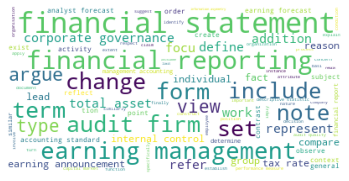

time: 253 ms


In [134]:
import matplotlib.pyplot as plt

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [135]:
NUM_OF_TOPICS = 30
NUM_OF_WORDS_IN_EACH_TOPIC = 20

time: 488 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [136]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

time: 604 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Unigrams

In [137]:
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=stop_list).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(dt3c['content_10'], NUM_OF_WORDS_IN_EACH_TOPIC)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top {} unigrams in the paper after removing stop words".format(NUM_OF_WORDS_IN_EACH_TOPIC)))
fig.show()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list_of_most_common_surnames', 'll', 'male', 'names', 'org', 'rep', 'shouldn', 've', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.



time: 51.8 s


## Bigrams

In [138]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=stop_list).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(dt3c['content_10'], NUM_OF_WORDS_IN_EACH_TOPIC)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top {} bigrams in the paper after removing stop words".format(NUM_OF_WORDS_IN_EACH_TOPIC)))
fig.show()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 2min 18s


In [90]:
"""
dt3c = pd.DataFrame(dt, columns=['file_path', 'Author', 'date', 'title'])
dt3c['content_3'] = dt['en_clean_content_3_stop_words_lemma']

dt3c.info()

unknown_lang_indexes = dt.index[dt['en_clean_content_3_lang'].str.match('UNKNOWN')]
dt3c = dt3c.drop(unknown_lang_indexes)

dt3c.info()
dt3c.reset_index(drop=True, inplace=True)
dt3c.info()
"""

In [99]:
dt3c.info()

In [139]:
import pyLDAvis
import pyLDAvis.sklearn

count_vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words=stop_list,             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000,          
                            )

data_vectorized = count_vectorizer.fit_transform(dt3c['content_10'])

lda_model = LatentDirichletAllocation(n_components=NUM_OF_TOPICS, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.



time: 4min 9s


## Visualize topics
By default the topics are projected to the 2D plane using PCoA on a distance matrix created using the <a href="https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence">Jensen-Shannon divergence</a> on the topic-term distributions. You can pass in a different multidimensional scaling function via the mds parameter. In addition to <b>pcoa</b>, other provided options are <b>tsne</b> and <b>mmds</b> which operate on the same JS-divergence distance matrix. Both tsne and mmds require that you have sklearn installed. 


Dimension reduction via Jensen-Shannon Divergence &
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html">TSNE - t-distributed Stochastic Neighbor Embedding</a>
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html#sklearn.manifold.MDS">MMDS - Metric Multidimensional Scaling</a> <a href="https://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html">Check Example</a>
- <a href="">PCOA - Principal Coordinate Analysis(aka Classical Multidimensional Scaling)</a>

Answer: https://stackoverflow.com/questions/50923430/what-does-the-parameter-mds-mean-in-the-pyldavis-sklearn-prepare-function

We used tsne below. Check for others: https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb
Also check to learn how LDAVis works: https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
And check the LDAVis from the original paper: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
Why LDAVis presentation: https://speakerdeck.com/bmabey/visualizing-topic-models

In [140]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, count_vectorizer, mds='tsne')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
5      119.070190   64.655502       1        1  7.813945
13      54.382130  109.799164       2        1  7.606734
8     -161.423965 -103.744957       3        1  6.781499
2     -135.370758   36.673065       4        1  4.786661
28     177.317215  -66.872452       5        1  4.739007
12     -16.436356  142.453796       6        1  4.174838
25      31.052383  204.777573       7        1  4.152555
1      -25.024384 -186.083466       8        1  4.059059
21     -68.157486   20.934038       9        1  3.627699
20      -3.751695    4.961509      10        1  3.625985
18    -114.470009 -179.605469      11        1  3.623322
4     -110.729126  -40.476776      12        1  3.430327
10      42.552418  -42.789406      13        1  3.151004
23     -10.661536   71.922211      14        1  3.109075
7      112.652969  -16.279951      15        1  2.955037
29    -195.499146  -25.853945      16        1  2.952056
0     -207.165924   66.070419      17        1  2.914369
15      10.217649 -110.752060      18        1  2.829687
9      -81.255081   96.477776      19        1  2.789094
16     -77.253441  192.755219      20        1  2.765819
26     182.353027  110.412880      21        1  2.586350
22      89.766510  -93.997673      22        1  2.473152
3      -36.483528  -52.542774      23        1  2.260762
17     -72.052170 -112.144821      24        1  2.183391
19     144.822769 -150.811508      25        1  2.010654
27    -148.475357  135.678162      26        1  1.615381
24     189.811615   17.382956      27        1  1.513179
11      56.555355   33.755768      28        1  1.386019
14      58.988537 -178.376541      29        1  1.217264
6      110.556717  164.236694      30        1  0.866074, topic_info=                    Term           Freq          Total Category  logprob  \
1873                firm  408772.000000  408772.000000  Default  30.0000   
3920                risk  101126.000000  101126.000000  Default  29.0000   
342                audit  140482.000000  140482.000000  Default  28.0000   
1463             earning  164533.000000  164533.000000  Default  27.0000   
4478                 tax   94981.000000   94981.000000  Default  26.0000   
346              auditor  122007.000000  122007.000000  Default  25.0000   
201              analyst   66684.000000   66684.000000  Default  24.0000   
1008                cost  112263.000000  112263.000000  Default  23.0000   
1907            forecast   59643.000000   59643.000000  Default  22.0000   
3238         performance   95221.000000   95221.000000  Default  21.0000   
1322          disclosure   81819.000000   81819.000000  Default  20.0000   
45            accounting  181304.000000  181304.000000  Default  19.0000   
2321         information  163074.000000  163074.000000  Default  18.0000   
1864           financial  147575.000000  147575.000000  Default  17.0000   
672               client   48004.000000   48004.000000  Default  16.0000   
959              control   97812.000000   97812.000000  Default  15.0000   
297                asset   66739.000000   66739.000000  Default  14.0000   
2729              market  130398.000000  130398.000000  Default  13.0000   
750              company  104000.000000  104000.000000  Default  12.0000   
3892              return   74473.000000   74473.000000  Default  11.0000   
3090              option   25383.000000   25383.000000  Default  10.0000   
2706             manager   89804.000000   89804.000000  Default   9.0000   
2254              income   51223.000000   51223.000000  Default   8.0000   
48               accrual   39056.000000   39056.000000  Default   7.0000   
539              capital   56188.000000   56188.000000  Default   6.0000   
3815              report  146990.000000  146990.000000  Default   5.0000   
992            corporate   54446.000000   54446.000000  Default   4.0000   
2474 

time: 16.7 s


In [141]:
print(count_vectorizer)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=5000, min_df=3,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=frozenset({'(former', '.002%.', '1990', '>', 'a',
                                      "a's", 'aaron', 'abbey', 'abbie',
                                      'abbott', 'abby', 'abdul', 'abdullah',
                                      'abe', 'abel', 'abell', 'abercrombie',
                                      'abernathy', 'abeyta', 'abigail', 'able',
                                      'ables', 'abner', 'abney', 'about',
                                      'above', 'abraham', 'abram', 'abrams',
                                      'abramson', ...}),
                strip_accents=None, token_pattern='[a-zA-Z0-9]{3,}',
                tokenizer=None, vocabulary=None)
time: 88 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [142]:
print(data_vectorized.toarray())

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
time: 255 ms


In [143]:
topic_names = []
for i in range(NUM_OF_TOPICS):
  topic_names.append("Topic {}".format(i+1))

time: 592 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [144]:
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=count_vectorizer, lda_model=lda_model, n_words=NUM_OF_WORDS_IN_EACH_TOPIC)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords['topic_theme'] = topic_names
df_topic_keywords.set_index('topic_theme', inplace=True)
df_topic_keywords.T

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



topic_theme         Topic 1         Topic 2      Topic 3         Topic 4  \
Word 0              analyst      disclosure   accounting        employee   
Word 1             forecast          report    financial            work   
Word 2              earning         company     standard    organisation   
Word 3                 firm     information      account  organisational   
Word 4          information   environmental    statement      individual   
Word 5           management       corporate       report           trust   
Word 6             investor        disclose    reporting          worker   
Word 7                issue     stakeholder         base         control   
Word 8       recommendation       reporting     economic             job   
Word 9              manager       financial          set           study   
Word 10            accuracy           study       market      accounting   
Word 11            guidance       voluntary        issue    relationship   
Word 12            revision  sustainability  information       behaviour   
Word 13               error         provide    principle          labour   
Word 14            research             csr      require         culture   
Word 15            coverage           issue         user           level   
Word 16         expectation          social     practice         manager   
Word 17             provide        investor    framework          people   
Word 18                news         include       method        research   
Word 19              report     performance      provide          social   

topic_theme       Topic 5         Topic 6       Topic 7      Topic 8  \
Word 0             market          social        option   governance   
Word 1           investor      accounting      covenant    corporate   
Word 2             return         account   negotiation     director   
Word 3       announcement        practice      exercise  shareholder   
Word 4            trading        critical    adjustment      company   
Word 5              trade     perspective         share   management   
Word 6        information            work    volatility    ownership   
Word 7             period         society       expense    financial   
Word 8              event            form           pro    committee   
Word 9              share  accountability      employee       member   
Word 10              firm        economic         forma      control   
Word 11              news            role          firm  independent   
Word 12           earning           paper         issue    executive   
Word 13           insider          theory          base        study   
Word 14          reaction          action     violation       agency   
Word 15          abnormal         process        equity      monitor   
Word 16            volume           actor     executive    structure   
Word 17            result         context      estimate         role   
Word 18           release          people           sfa    mechanism   
Word 19          negative            view  compensation   monitoring   

topic_theme      Topic 9   Topic 10        Topic 11         Topic 12  \
Word 0            return       debt      government             risk   
Word 1             model      asset          public          segment   
Word 2          variable     credit          sector      uncertainty   
Word 3            market  financial           local       derivative   
Word 4          estimate     rating       political         increase   
Word 5           measure    pension          reform           factor   
Word 6            result       bank          policy             firm   
Word 7              test       loss  accountability         exposure   
Word 8            equity     equity         private       volatility   
Word 9            growth       rate        economic            risky   
Word 10       regression  liability         economy         business   
Word 11            ratio  

time: 96.4 ms


# 2. Topic Modeling

In [145]:
# Create Document - Topic Matrix
lda_output2 = lda_model.transform(data_vectorized)

# column names
topicnames = df_topic_keywords.T.columns

# index names
docnames = ["Doc" + str(i) for i in range(len(dt3c))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output2, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.reset_index(inplace=True)
df_sent_topic= pd.merge(dt3c, df_document_topic, left_index=True, right_index=True)
df_sent_topic.drop('index', axis=1, inplace=True)

df_topic_theme = df_sent_topic[['file_path', 'dominant_topic']]

def label_theme(row):
    return "Topic " + str(row)
        
df_topic_theme['dominant_topic_theme'] = df_topic_theme['dominant_topic'].apply(label_theme)
df_topic_theme.head(15)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-145-9689e41583c7>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



file_path  \
0   /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   
1   /Users/farukcankaya/Google Drive/AllPapers/8_AH/611_AH.pdf   
2   /Users/farukcankaya/Google Drive/AllPapers/8_AH/123_AH.pdf   
3   /Users/farukcankaya/Google Drive/AllPapers/8_AH/672_AH.pdf   
4   /Users/farukcankaya/Google Drive/AllPapers/8_AH/394_AH.pdf   
5   /Users/farukcankaya/Google Drive/AllPapers/8_AH/398_AH.pdf   
6   /Users/farukcankaya/Google Drive/AllPapers/8_AH/298_AH.pdf   
7   /Users/farukcankaya/Google Drive/AllPapers/8_AH/603_AH.pdf   
8   /Users/farukcankaya/Google Drive/AllPapers/8_AH/152_AH.pdf   
9   /Users/farukcankaya/Google Drive/AllPapers/8_AH/386_AH.pdf   
10  /Users/farukcankaya/Google Drive/AllPapers/8_AH/286_AH.pdf   
11  /Users/farukcankaya/Google Drive/AllPapers/8_AH/760_AH.pdf   
12  /Users/farukcankaya/Google Drive/AllPapers/8_AH/748_AH.pdf   
13  /Users/farukcankaya/Google Drive/AllPapers/8_AH/482_AH.pdf   
14  /Users/farukcankaya/Google Drive/AllPapers/8_AH/164_AH.pdf   

    dominant_topic dominant_topic_theme  
0               13             Topic 13  
1               20             Topic 20  
2                7              Topic 7  
3                0              Topic 0  
4               12             Topic 12  
5                4              Topic 4  
6               13             Topic 13  
7               12             Topic 12  
8                9              Topic 9  
9               22             Topic 22  
10              15             Topic 15  
11               8              Topic 8  
12              12             Topic 12  
13              13             Topic 13  
14              12             Topic 12

time: 13.2 s


## Make Prediction

In [146]:
print(lda_output.shape) # (11682, 8)
topic_sum = pd.DataFrame(np.sum(lda_output, axis = 1))
print(topic_sum.shape) # (11682, 1)

(11014, 30)
(11014, 1)
time: 1.98 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [147]:
column_names = ['file_path', 'content_10'] + topic_names + ['sum']

# Turn our docs_nmf array into a data frame
doc_topic_df = pd.DataFrame(data = lda_output)

# Merge all of our article metadata and name columns
doc_topic_df = pd.concat([dt3c[['file_path', 'content_10']], 
                          doc_topic_df, topic_sum], axis = 1)


time: 85.5 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [148]:
doc_topic_df.columns = column_names

time: 533 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [149]:
doc_topic_df.head(1)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



file_path  \
0  /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

time: 37.5 ms


In [150]:
doc_topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11014 entries, 0 to 11013
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_path   11014 non-null  object 
 1   content_10  11014 non-null  object 
 2   Topic 1     11014 non-null  float64
 3   Topic 2     11014 non-null  float64
 4   Topic 3     11014 non-null  float64
 5   Topic 4     11014 non-null  float64
 6   Topic 5     11014 non-null  float64
 7   Topic 6     11014 non-null  float64
 8   Topic 7     11014 non-null  float64
 9   Topic 8     11014 non-null  float64
 10  Topic 9     11014 non-null  float64
 11  Topic 10    11014 non-null  float64
 12  Topic 11    11014 non-null  float64
 13  Topic 12    11014 non-null  float64
 14  Topic 13    11014 non-null  float64
 15  Topic 14    11014 non-null  float64
 16  Topic 15    11014 non-null  float64
 17  Topic 16    11014 non-null  float64
 18  Topic 17    11014 non-null  float64
 19  Topic 18    11014 non-nul

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [151]:
# Remove articles with topic sum = 0, then drop sum column
doc_topic_df = doc_topic_df[doc_topic_df['sum'] != 0]
doc_topic_df.drop(columns = 'sum', inplace = True)

# Reset index then save
doc_topic_df.reset_index(drop = True, inplace = True)
#doc_topic_df.to_pickle('counter_vectorizer_LDA_8topics_stemmed.pkl')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 7.77 ms


In [152]:
doc_topic_df.info()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11014 entries, 0 to 11013
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_path   11014 non-null  object 
 1   content_10  11014 non-null  object 
 2   Topic 1     11014 non-null  float64
 3   Topic 2     11014 non-null  float64
 4   Topic 3     11014 non-null  float64
 5   Topic 4     11014 non-null  float64
 6   Topic 5     11014 non-null  float64
 7   Topic 6     11014 non-null  float64
 8   Topic 7     11014 non-null  float64
 9   Topic 8     11014 non-null  float64
 10  Topic 9     11014 non-null  float64
 11  Topic 10    11014 non-null  float64
 12  Topic 11    11014 non-null  float64
 13  Topic 12    11014 non-null  float64
 14  Topic 13    11014 non-null  float64
 15  Topic 14    11014 non-null  float64
 16  Topic 15    11014 non-null  float64
 17  Topic 16    11014 non-null  float64
 18  Topic 17    11014 non-null  float64
 19  Topic 18    11014 non-nul

In [153]:
doc_topic_df[['file_path']+topic_names].head(3).T

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0  \
file_path  /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   
Topic 1                                                   1.70068e-05   
Topic 2                                                   1.70068e-05   
Topic 3                                                   1.70068e-05   
Topic 4                                                   1.70068e-05   
Topic 5                                                   1.70068e-05   
Topic 6                                                     0.0953288   
Topic 7                                                   1.70068e-05   
Topic 8                                                   1.70068e-05   
Topic 9                                                   1.70068e-05   
Topic 10                                                  1.70068e-05   
Topic 11                                                   0.00300196   
Topic 12                                                  1.70068e-05   
Topic 13                                                  1.70068e-05   
Topic 14                                                     0.381317   
Topic 15                                                  1.70068e-05   
Topic 16                                                  1.70068e-05   
Topic 17                                                  1.70068e-05   
Topic 18                                                  1.70068e-05   
Topic 19                                                  1.70068e-05   
Topic 20                                                  1.70068e-05   
Topic 21                                                  1.70068e-05   
Topic 22                                                    0.0181061   
Topic 23                                                  1.70068e-05   
Topic 24                                                  1.70068e-05   
Topic 25                                                  1.70068e-05   
Topic 26                                                     0.106283   
Topic 27                                                     0.168024   
Topic 28                                                     0.227548   
Topic 29                                                  1.70068e-05   
Topic 30                                                  1.70068e-05   

                                                                    1  \
file_path  /Users/farukcankaya/Google Drive/AllPapers/8_AH/611_AH.pdf   
Topic 1                                                   1.78253e-05   
Topic 2                                                   1.78253e-05   
Topic 3                                                   1.78253e-05   
Topic 4                                                   1.78253e-05   
Topic 5                                                     0.0723372   
Topic 6                                                   1.78253e-05   
Topic 7                                                   1.78253e-05   
Topic 8                                                   1.78253e-05   
Topic 9                                                      0.140968   
Topic 10                                                  1.78253e-05   
Topic 11                                                  1.78253e-05   
Topic 12                                                  1.78253e-05   
Topic 13                                                     0.312478   
Topic 14                                                  1.78253e-05   
Topic 15                                                  1.78253e-05   
Topic 16                                                   0.00787587   
Topic 17                                                  1.78253e-05   
Topic 18                                                  1.78253e-05   
Topic 19                                                  1.78253e-05   
Topic 20                                                   0.00628494   
Topic 21                                                     0.424883   
Topic 22                                            

time: 15.5 ms


In [154]:
topic_array = np.array(doc_topic_df[topic_names])

print(topic_array.shape)

print(topic_array[0])

(11014, 30)
[1.70068027e-05 1.70068027e-05 1.70068027e-05 1.70068027e-05
 1.70068027e-05 9.53287742e-02 1.70068027e-05 1.70068027e-05
 1.70068027e-05 1.70068027e-05 3.00196056e-03 1.70068027e-05
 1.70068027e-05 3.81317014e-01 1.70068027e-05 1.70068027e-05
 1.70068027e-05 1.70068027e-05 1.70068027e-05 1.70068027e-05
 1.70068027e-05 1.81061304e-02 1.70068027e-05 1.70068027e-05
 1.70068027e-05 1.06282989e-01 1.68023683e-01 2.27548292e-01
 1.70068027e-05 1.70068027e-05]
time: 8.86 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [155]:
import pickle

NUM_OF_TOPICS = 30
NUM_OF_WORDS_IN_EACH_TOPIC = 20

topic_names = []
for i in range(NUM_OF_TOPICS):
  topic_names.append("Topic {}".format(i+1))

topic_array = np.array(doc_topic_df[topic_names])
norms = np.linalg.norm(topic_array, axis = 1)

pickle.dump( norms, open( "model__norms.pkl", "wb" ) )
pickle.dump( topic_array, open( "model__topic_array.pkl", "wb" ) )
df_topic_keywords.to_pickle('model__df_topic_keywords.pkl')
pickle.dump( doc_topic_df, open( "model__doc_topic_df.pkl", "wb" ) )
pickle.dump( lda_model, open( "model__lda_model.pkl", "wb" ) )
pickle.dump( count_vectorizer, open( "model__count_vectorizer.pkl", "wb" ) )
pickle.dump( stop_list, open( "model__stop_list.pkl", "wb" ) )



/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 995 ms


In [ ]:
"""
norms     = pickle.load( open( "model__norms.pkl", "rb" ) )
topic_array     = pickle.load( open( "model__topic_array.pkl", "rb" ) )
df_topic_keywords = pickle.load( open( "model__df_topic_keywords.pkl", "rb" ) )
doc_topic_df = pickle.load( open( "model__doc_topic_df.pkl", "rb" ) )
lda_model = pickle.load( open( "model__lda_model.pkl", "rb" ) )
count_vectorizer   = pickle.load( open( "model__count_vectorizer.pkl", "rb" ) )
stop_list     = pickle.load( open( "model__stop_list.pkl", "rb" ) )
"""

### Add Title, Author, metadata to core model

In [156]:
x = dt3c.copy()
# Paper Name, Author Name(s), Year and Journal
print(x['date'].isna().sum())
x['date'] = x['date'].fillna(0)
print(x['date'].isna().sum())

doc_topic_df['year'] = x['date']

12
0
time: 21.4 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [157]:
def combine_authors(author_list):
  if isinstance(author_list, list):
    return ', '.join(author_list)

  return author_list

x['Author'] = x['Author'].fillna('-')
x['authors'] = x['Author'].apply(combine_authors)

doc_topic_df['authors'] = x['authors']

time: 9.63 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [158]:
print(x['title'].isna().sum())
x['title'] = x['title'].fillna('-')
print(x['title'].isna().sum())

doc_topic_df['title'] = x['title']

963
0
time: 5.71 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [159]:
def journal_name(text):
  text = get_file_name(text)
  t = re.findall('([0-9]+)_([a-zA-Z]+)', text, re.IGNORECASE)
  return [i[1] for i in t][0]

doc_topic_df['journal'] = x['file_path'].apply(journal_name)
doc_topic_df['journal'].head(5)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0    AH
1    AH
2    AH
3    AH
4    AH
Name: journal, dtype: object

time: 49 ms


In [110]:
rt = pd.read_excel('/Users/farukcankaya/FC/GoogleDrive/DATA_RELEVANT.xlsx')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.it

time: 11.2 s


In [160]:
rt.iloc[rt.index[rt['Filename'].str.match(get_file_name(dt['file_path'][0]))][0]]['Title']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



'The effect of system characteristics, stage of adoption, and experience on institutional explanations for ERP systems choice'

time: 34.3 ms


In [161]:
titles = []
for i in range(0, len(dt3c['file_path'])):
  if rt['Filename'].str.match(get_file_name(dt3c['file_path'][i])).any():
    titles.append(rt.iloc[rt.index[rt['Filename'].str.match(get_file_name(dt3c['file_path'][i]))][0]]['Title'])
  else:
    titles.append(dt3c['title'][i])
      

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 2min 42s


In [162]:
pickle.dump( doc_topic_df, open( "model__doc_topic_df.pkl", "wb" ) )

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 678 ms


In [163]:
def compute_dists(top_vec, topic_array):
    '''
    Returns cosine distances for top_vec compared to every article
    '''
    dots = np.matmul(topic_array, top_vec)
    input_norm = np.linalg.norm(top_vec)
    co_dists = dots / (input_norm * norms)
    return co_dists
  
def produce_rec(top_vec, topic_array, doc_topic_df, rand = 15):
    '''
    Produces a recommendation based on cosine distance.
    rand controls magnitude of randomness.
    '''
#    top_vec = top_vec + np.random.rand(30,)/(np.linalg.norm(top_vec)) * rand
    co_dists = compute_dists(top_vec, topic_array)
    return doc_topic_df.loc[np.argmax(co_dists)]

time: 940 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [164]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Define function to predict topic for a given new question.
def predict_topic(text, nlp=nlp):
    global sent_to_words

    # Clean
    for i in range(len(text)):
      text[i] = clean_text(text[i])
      
    # Remove stopwords
    for i in range(len(text)):
      text[i] = remove_stopwords(text[i])
    
    # Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Lemmatize is skipped !!!
    # mytext_3_1 = []
    # for sent in mytext_2:
    #   mytext_3_1.append(" ".join(sent))
    # Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    #print('Text after lemmatization ({} characters):'.format(len(mytext_3[0])))
    #print(mytext_3[0][0:100]+" ...")
    
    # stemming is skipped !!!
    #mytext_3_1 = []
    #for t in mytext_3:
    #  mytext_3_1.append(stem_text(t))
    
    # Vectorize transform
    mytext_4 = count_vectorizer.transform(mytext_3)
    
    #print('Count vectorizer of transformed text: {}'.format(mytext_4.shape))
    #print('Vectorized data {}'.format(data_vectorized.shape))
    #print('First 100 Feature names:')
    #print(count_vectorizer.get_feature_names()[:100])
    #print('')
    

    # LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

time: 1.91 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# Make single prediction

In [165]:
# Predict the topic
TAR_6 = ["We examine how subjective performance evaluations are influenced by the level and controllability of an accompanying measure of a separate performance dimension. In our experiment, supervisors evaluate the office administration perfor- mance of a hypothetical subordinate. We find that supervisors’ subjective evaluations are directionally influenced by an accompanying objective measure of sales perfor- mance, even after excluding participants who perceive informativeness across measures. Consistent with concerns for fairness and motivation, we also find an asymmetric uncontrollability effect—supervisors’ evaluations are higher when an uncontrollable factor decreases the subordinate’s sales (i.e., they compensate for bad luck), but are not lower when the uncontrollable factor increases the subordinate’s sales (i.e., they do not punish for good luck). This evidence suggests that supervisors use discretion provided to evaluate performance on one task to adjust for perceived deficiencies in the evaluation of performance on other tasks. Our study integrates theories of cognitive bias and motivation, highlighting the need to consider the potentially interactive effects of different performance measures in multi-task settings I. INTRODUCTION Organizational incentive systems often allow managerial discretion in the evaluation of employee performance (Murphy and Oyer 2003). Subjective performance evaluation allows managers to use noncontractible information to assess actions and efforts that objective measures (such as those produced by the accounting system) are not able to capture, creating a more complete depiction of employee performance (Bol 2008).1 Subjectivity can therefore be useful in reducing risk to employees and improving the incentive alignment of the firm’s performance measurement system (Baker et al. 1994; Bushman et al. 1996; Hayes and Schaefer 2000).2 Many performance measurement systems include both objective measures and subjective evaluations (Prendergast 1999; Gibbs et al. 2004). While designed to capture separate dimensions of employee performance, these different measurement types can influence each other. For example, theories from psychology and organizational behavior suggest that subjective judgments can be unduly influenced by an individual’s knowledge of other, unrelated information (Nisbett et al. 1981; Bond et al. 2007). Such an influence could limit the complementary role of subjective evaluation in improving the overall informativeness of the measures used to evaluate performance. We examine how supervisors’ subjective performance evaluations are affected by the level and controllability of an objective measure of a separate aspect of performance. We analyze a two-dimensional employment setting in which an employee’s performance on one dimension (i.e., task) is measured objectively, while performance on the other dimension is evaluated subjectively by the supervisor. In many such settings, the objective performance measure is known by the supervisor before s/he subjectively evaluates the employee’s performance on the other dimension (Huber et al. 1987; Bommer et al. 1995). Our first research question examines whether the level of the objective measure has a directional impact on the supervisor’s subjective evaluation. Specifically, we examine whether, consistent with cognitive distortion, supervisors bias their subjective evaluations of performance on one dimension to be consistent with an objective measure of performance on a separate and unrelated dimension.3 Our second research question considers how such a spillover effect differs when the controllability of the objective performance measure is relatively low. Uncontrollability introduces noise and error into the performance measurement system (Feltham and Xie 1994), and has been shown to affect attribution judgments (Tan and Lipe 1997). Employees are likely to perceive uncontrollable performance measures to be unfair when the uncontrollability reduces measured performance. Perceptions of unfairness in compensation lead to reduced job satisfaction and motivation (Cohen-Charash and Spector 2001; Colquitt et al. 2001). We examine whether this expectation is reflected in supervisors’ use of their discretion, even when that discretion is provided for the evaluation of a separate task. Specifically, we examine whether supervisors use the discretion in their subjective evaluations to adjust for (or offset) the effects of an uncontrollable objective measure. Consistent with concerns for fairness and employee motivation, we predict that supervisors will make such an adjustment when the uncontrollable factor reduces measured performance (i.e., the employee suffers from bad luck) but not when it increases measured performance (i.e., the employee benefits from good luck). In our experiment, experienced supervisors employed by a large state university participate as evaluators in a hypothetical case setting. Participants assume the role of a regional director with supervisory authority over district managers who have both sales- and office administration-related duties. Objective individual sales information is given, after which participants are charged with subjectively evaluating the office administration performance of one district manager based on personal notes and staff interview responses, which are held constant in all conditions. The experiment employs a 2 3 2 þ 1 between-subjects design. In four treatment conditions, we manipulate the level of the manager’s individual sales at two levels by varying the objective sales score (high and low), and we manipulate the controllability of the individual sales measure at two levels by varying whether significant but uncontrollable events impacted the manager’s sales during the period. A fifth (control) condition includes only the information about the manager’s office administration performance. We find that supervisors’ subjective evaluations of the manager’s office administration performance are significantly higher (lower) when the objective level of the manager’s individual sales measure is relatively high (low). By excluding those participants who perceived the individual sales measure to be informative about the manager’s office administration performance in our primary analysis, we provide evidence of cognitive distortion of performance information as a result of exposure to the objective measure. We also find that the effect of the objective measure depends on its controllability. Specifically, participants use their subjective evaluations to adjust for the impact of uncontrollable events on the sales measure. Consistent with theory, this effect is asymmetric—participants’ evaluations are higher (relative to the high controllability condition) when the uncontrollable factor leads to an unfavorable outcome, but are no lower when the uncontrollable factor leads to a favorable outcome. Thus, we find that participants use their discretion to compensate for bad luck, but not to punish for good luck. This study contributes to the accounting and management literatures on performance evaluation. Prior research on bias in performance evaluation has found that supervisors’ subjective evaluations of current performance may be directionally influenced by prior performance information (Murphy et al. 1985; Huber et al. 1987; Kravitz and Balzer 1992) or information from different sources (Blakely 1993; Murphy and Cleveland 1995; Bono and Colbert 2005). Our study contributes to this line of research by showing that cognitive distortion can cause spillover from the objective evaluation of one dimension of performance to the subjective evaluation of performance on a separate and unrelated dimension. Prior research has also found evidence that controllability concerns can affect evaluators’ judgments in single-dimension performance-evaluation settings. For example, Tan and Lipe (1997) find that controllability moderates outcome effects in evaluators’ judgments (also see Brown and Solomon 1987). Our study reveals a very different controllability effect. Specifically, our results suggest that supervisors can use discretion that is provided for the evaluation of performance on a particular dimension to ‘‘correct’’ perceived deficiencies in other areas of the evaluation system. While the use of ‘‘borrowed’’ discretion can yield motivational benefits for employees, the intended benefits of that discretion (i.e., accurate reflection of performance on a specific dimension) can be reduced. Overall, our evidence indicates that the known level of an objective performance measure compromises the effectiveness of subjective performance evaluation for completing the picture of employee performance. Thus, our results have implications for the weight, timing, and nature of subjectivity in compensation contracting, suggesting that consideration of different measurement types in isolation can lead to incomplete conclusions about the optimal design of performance measurement systems. An asymmetric pattern of compensation payouts, in which managers are sheltered from downside risk but are allowed the advantages of upside risk, has been demonstrated in accounting"]
AOS_3 = ["This paper is focused on the way in which inter®rm relations can be drawn up and controlled. Drawing on con- tracting theories a model is built of the management control structure of inter®rm relationships. The model consists of three control patterns and of contingency factors that in ̄uence the choices between the patterns. Particular attention is paid to the role of trust. In building our model we take the perspective of the outsourcer. We try to re®ne our model by conducting case research in the ®eld of industrial renovation and industrial maintenance. In this ®eld we observed changes in the way outsourcing relationships are controlled. Case research can be very helpful for gaining insights into factors that in ̄uence the establishment of control structures of inter®rm relationships. By comparing the results of our case research we found institutional, strategic, cultural and historical factors to be of great importance for these control structures. 5 1999 Elsevier Science Ltd. All rights reserved. The boundaries of ®rms are continuously sub- ject to changes. Firms add new activities, hive o􏰁 existing activities and set up new forms of coop- eration with other ®rms. The concentration on core activities is a tendency that already started several years ago. Non-core activities are hived o􏰁, so that the ®rm can concentrate on the activ- ities which it can perform well and which can thus produce the highest added value. Insight into which activities belong to the non-core activities is subject to changes too. We observe that conglom- erates with a great variety of products hive o complete product lines, but we also ®nd that ®rms, although they do not change their product mix, leave the production of components to other ®rms. We can also observe that ®rms outsource the provision of supporting services even more. Even services which are essential for the continuity of the ®rm, such as administration, information technology and maintenance. When the out- sourcing concerns essential components and ser- vices we observe the setting up of close forms of cooperation between ®rms. Hiving o􏰁 essential components and services requires a speci®c embeddedness of the outsourcing relation in order to guarantee its continuity and to retain the eco- nomic advantages of outsourcing in the long run. This makes demands on the macro as well as micro level. On the macro level these develop- ments must be supported by legal and institutional frameworks (such as contract law and the attitude of branch organisations and the trade unions). On the micro level they make demands on the orga- nisation of the ®rm's own activities, the coordina- tion with the suppliers and the employees' willingness to work closely together with people from outside their own ®rm. The structuring and control of inter®rm relations require the establish- ment of suitable management control systems and processes. This study is in particular aimed at the demands outsourcing relations make on the micro level. The question is: how can ®rms which enter into strategic alliances with other ®rms structure the management control of such inter®rm relationships? Management control and management accounting research usually concentrates on rela- tions within organisations with varying degrees of decentralisation of decision making. Robert Anthony's (1965, 1988) well-known framework in which the decomposition of the organisation into responsibility centers is paramount, is the implicit or explicit point of departure for a lot of formal behavioural and contingency research in manage- ment control. In numerous organisations a hor- izontalisation of management control relations can be observed. These control relations are not hierarchically based but are relations between equal internal parties. Customer-supplier relation systems are being set up with forms of internal contracting (service level agreements), e.g. with respect to facility services (Van der Meer-Kooistra, 1994; Vosselman, 1996). There used to be captive buyers and sellers, but now it is no longer excep- tional for departments to be allowed to deliver or to buy on external markets within rather  ̄exible limits. Otley (1994) too observes such a horizontalisation and proposes a broader management control fra- mework. Research into horizontal management control relations should not remain restricted to intra®rm relations, but be extended to inter®rm relations. Recently Hopwood urged ``(the) exam- ination of some of the accounting and informational consequences of more explicit concerns with the management of the supply chain and a more con- scious questioning of what activities reside within and without the enterprise'' (Hopwood, 1996, p. 590). In the relevant literature little attention is given to management control issues with regard to forms of cooperation between independent com- panies (inter®rm relations). It is in particular the strategic cost management literature (Cooper, 1995; Shank & Govindarajan, 1993) which draws attention to the importance of looking beyond the boundaries of the ®rm. These publications emphasise the value chain approach, which not only focuses on the relations between the various subsequent activities within the ®rm but also on the ®rm's relations with the suppliers of raw materials, components etc. and the buyers. Berry (1995) also focuses on extra-organisational control problems, in particular control in network orga- nisations. According to Gietzmann (1996) the role of the management accountant is changing due to control beyond the boundaries of the concern. When deciding on what should or should not be contracted out this role is much more complex than just calculating the production costs and comparing them with the market price. Make or buy decisions are becoming more and more of a strategic nature (see e.g. Tayles & Drury, 1997). ``The management accountant should play a cri- tical support role in the strategy debate concerning which elements (subcomponents) of product development can be outsourced, which should be developed in house and which do not warrant development since o􏰁 the shelf subcomponents su􏰂ce'' (Gietzmann, p. 624). Therefore the man- agement accountant needs not only information about the production costs and market prices but he also needs information about the costs and bene®ts of the speci®c forms of governance connected with these choices. Nowadays many make or buy decisions have evolved into what could be called `extended make or buy' decisions. An extended make or buy deci- sion can be divided into three separate, but inter- related elements. Firstly, the decision to purchase goods or services on a structural basis from third parties or to produce the goods or services in- house. Secondly, in the case of purchasing from third parties, the decision regarding the party or parties contracted. The nature of the party or parties in ̄uences the chance, and extent, of relational risks. Thirdly, decisions regarding the design of the internal management control system or the design of the outsourcing relationship."]
topic, prob_scores = predict_topic(text = TAR_6)
print('topic')
print(topic)
print('')
print('prob_scores')
print(prob_scores[0])
print("shape of prob_scores: {}".format(prob_scores[0].shape))
print('')


print("Try to make recommendation. Inputs:")
print("- prob_scores")
print("- topic_array: {} prob. distribution of topics for each document that is calculated by LDA".format(topic_array.shape))
print("- doc_topic_df: {} that is actually output of the LDA but combined with file_path, etc.".format(doc_topic_df.shape))
print('')

produce_rec(prob_scores.flatten(), topic_array, doc_topic_df)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



topic
['performance', 'manager', 'measure', 'incentive', 'compensation', 'firm', 'pay', 'executive', 'base', 'contract', 'managerial', 'bonus', 'increase', 'ceo', 'effect', 'effort', 'level', 'result', 'employee', 'plan']

prob_scores
[6.25390869e-05 6.25390869e-05 6.25390869e-05 4.45669516e-02
 6.25390869e-05 6.25390869e-05 6.25390869e-05 6.25390869e-05
 6.25390869e-05 6.25390869e-05 6.25390869e-05 1.47066401e-02
 6.25390869e-05 6.25390869e-05 6.25390869e-05 6.25390869e-05
 6.25390869e-05 6.25390869e-05 1.13408293e-02 6.25390869e-05
 6.25390869e-05 6.25390869e-05 6.25390869e-05 4.18767081e-01
 6.25390869e-05 3.44424456e-01 1.64693104e-01 6.25390869e-05
 6.25390869e-05 6.25390869e-05]
shape of prob_scores: (30,)

Try to make recommendation. Inputs:
- prob_scores
- topic_array: (11014, 30) prob. distribution of topics for each document that is calculated by LDA
- doc_topic_df: (11014, 36) that is actually output of the LDA but combined with file_path, etc.



file_path                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

time: 637 ms


# Calculate Top-5 Accuracy

In [166]:
from sklearn.metrics.pairwise import cosine_similarity

def produce_rec_top_n(top_vec, topic_array, doc_topic_df, n=5):
    co_dists = compute_dists(top_vec, topic_array)
    index_top_n = np.argpartition(co_dists, -n)[-n:]
    index_top_n = index_top_n[np.argsort(-co_dists[index_top_n])]
    return doc_topic_df.loc[index_top_n]
  
topic, prob_scores = predict_topic(text = TAR_6)

topic_columns = ['Topic '+str(i) for i in range(1,df_topic_keywords.shape[0]+1)]
recs = produce_rec_top_n(prob_scores.flatten(), topic_array, doc_topic_df)

rec_top_1 = recs[topic_columns].head(1).values

print('rec_top_1:')
print(rec_top_1)
print('prob_scores:')
print(prob_scores.flatten())
print('cosine_similarity:')
print(cosine_similarity(rec_top_1,prob_scores))

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



rec_top_1:
[[1.23428916e-03 8.32500833e-06 8.32500833e-06 9.75645936e-02
  8.32500833e-06 8.32500833e-06 9.75754568e-03 2.09995173e-03
  8.32500833e-06 8.32500833e-06 8.32500833e-06 4.82134130e-02
  8.32500833e-06 8.32500833e-06 8.32500833e-06 8.32500833e-06
  8.32500833e-06 8.32500833e-06 2.33545986e-02 8.32500833e-06
  4.89718476e-04 8.32500833e-06 6.09474343e-03 3.86252703e-01
  8.32500833e-06 3.31659969e-01 9.31202990e-02 8.32500833e-06
  8.32500833e-06 8.32500833e-06]]
prob_scores:
[6.25390869e-05 6.25390869e-05 6.25390869e-05 4.45669516e-02
 6.25390869e-05 6.25390869e-05 6.25390869e-05 6.25390869e-05
 6.25390869e-05 6.25390869e-05 6.25390869e-05 1.47066401e-02
 6.25390869e-05 6.25390869e-05 6.25390869e-05 6.25390869e-05
 6.25390869e-05 6.25390869e-05 1.13408293e-02 6.25390869e-05
 6.25390869e-05 6.25390869e-05 6.25390869e-05 4.18767081e-01
 6.25390869e-05 3.44424456e-01 1.64693104e-01 6.25390869e-05
 6.25390869e-05 6.25390869e-05]
cosine_similarity:
[[0.98502843]]
time: 265 ms


In [167]:
recs['file_path']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



9454    /Users/farukcankaya/Google Drive/AllPapers/12_MAR/478_MAR.pdf
5772       /Users/farukcankaya/Google Drive/AllPapers/1_TAR/6_TAR.pdf
8281     /Users/farukcankaya/Google Drive/AllPapers/4_AOS/898_AOS.pdf
8419     /Users/farukcankaya/Google Drive/AllPapers/4_AOS/124_AOS.pdf
5724     /Users/farukcankaya/Google Drive/AllPapers/1_TAR/796_TAR.pdf
Name: file_path, dtype: object

time: 4.37 ms


In [168]:
def accuracy_n(file_path, data, top_n=[1]):
  topic, prob_scores = predict_topic([data])

  topic_columns = ['Topic '+str(i) for i in range(1,df_topic_keywords.shape[0]+1)]
  recs = produce_rec_top_n(prob_scores.flatten(), topic_array, doc_topic_df, max(top_n))

  existence = []
  
  for n in top_n:    
    if recs['file_path'].head(n).str.contains(get_file_name(file_path)).any():
      existence.append(1)
    else:
      existence.append(0)

  return pd.Series(existence)

time: 1.13 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [120]:
"""
top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
dt[col_acc_n] = dt.apply(lambda x: accuracy_n(x['file_path'], x['page_1'], top_n), axis=1)
dt.info()"""

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15751 entries, 0 to 15750
Columns: 2445 entries, file_path to acc_top_100
dtypes: float64(330), int64(337), object(1778)
memory usage: 293.8+ MB
time: 46min 53s


In [169]:
## PARALLEL TEST
xx = dt.copy().drop(unknown_lang_indexes)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], top_n), axis=1)
xx.info()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:390: UserWarning:

Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:390: UserWarning:

Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:390: UserWarning:

Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1

/

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15219 entries, 0 to 15750
Columns: 2445 entries, file_path to acc_top_100
dtypes: float64(330), int64(337), object(1778)
memory usage: 284.0+ MB
time: 8min 27s


In [172]:
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

Top-1 Score:0.15198107628622118
Top-5 Score:0.3024508837637164
Top-10 Score:0.37269202969971743
Top-20 Score:0.4475326894014061
Top-50 Score:0.5448452592154543
Top-100 Score:0.6064787436756686
time: 19.5 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
dt['acc_top_1'] = dt.apply(lambda x: accuracy_n(x['file_path'], x['page_1'], 1), axis=1)

In [ ]:
print('Top-1 Score:' + str(dt['acc_top_1'].sum()/dt['acc_top_1'].count()))

In [ ]:
dt['acc_top_10'] = dt.apply(lambda x: accuracy_n(x['file_path'], x['page_1'], 10), axis=1)

In [ ]:
print('Top-10 Score:' + str(dt['acc_top_10'].sum()/dt['acc_top_10'].count()))

In [ ]:
np.isnan(lda_output).any()

In [ ]:
topic_sum.isna().sum()

In [ ]:
doc_topic_df['file_path']

In [ ]:
lda_model

In [ ]:
lda_model = pickle.load( open( "model/lda_model.pkl", "rb" ) )

In [ ]:
lda_model

In [ ]:
lda_model.n_jobs = None

In [ ]:
lda_model